In [1]:
import pandas as pd
import numpy as np

## Binarize

In [2]:
df_train = pd.read_csv('../dataset/TrainingDataset.csv')
df_test = pd.read_csv('../dataset/TestDataset.csv')

# 1 & 2 -> 1
# 0 -> 0

binarized = df_train['3-class'].values.copy()
binarized[binarized == 2] = 1
df_train['2-class-merged-v1'] = binarized.astype(int)

binarized = df_test['3-class'].values.copy()
binarized[binarized == 2] = 1
df_test['2-class-merged-v1'] = binarized.astype(int)


y_train = df_train['2-class-merged-v1'].values
y_test = df_test['2-class-merged-v1'].values

## Use All Features

In [3]:
np.unique(df_train['residue'])

array(['C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q',
       'R', 'S', 'T', 'V', 'W', 'Y'], dtype=object)

In [4]:
# convert aa char to int
codes = ['A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 
         'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
code_to_int = {c:i for i,c in enumerate(codes)}     
df_train['residue'] = df_train['residue'].map(code_to_int)
df_test['residue'] = df_test['residue'].map(code_to_int)

In [5]:
np.unique(df_train['secondary structure'])

array(['-', 'H', 'S', 'T'], dtype=object)

In [6]:
# convert secondary structure char to int
codes = ['H', 'S', 'T', '-']
code_to_int = {c:i for i,c in enumerate(codes)}     
df_train['secondary structure'] = df_train['secondary structure'].map(code_to_int)
df_test['secondary structure'] = df_test['secondary structure'].map(code_to_int)

feature_list = ['avg bond number', 'Hbond', 'residue',
                'Hphob', 'consurf', "B' side chain", 'secondary structure', 'asa']

df_train = df_train[feature_list]
df_test = df_test[feature_list]

In [7]:
df_train['residue'] = df_train['residue'].astype('category')
df_test['residue'] = df_test['residue'].astype('category')

df_train['secondary structure'] = df_train['secondary structure'].astype('category')
df_test['secondary structure'] = df_test['secondary structure'].astype('category')

In [8]:
df_train.dtypes

avg bond number         float64
Hbond                     int64
residue                category
Hphob                     int64
consurf                   int64
B' side chain           float64
secondary structure    category
asa                     float64
dtype: object

In [9]:
X_train = df_train[feature_list].values
X_test =  df_test[feature_list].values

In [10]:
X_train.shape

(732, 8)

In [11]:
y_train.shape

(732,)

In [12]:
X_test.shape

(314, 8)

In [13]:
y_test.shape

(314,)

In [14]:
X_train[:, [2, 6]]

array([[13.,  3.],
       [ 1.,  1.],
       [14.,  3.],
       ...,
       [19.,  2.],
       [14.,  2.],
       [ 1.,  3.]])

## OneHot Encoding

In [15]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(drop='first')
ohe.fit(df_train[feature_list][['residue', 'secondary structure']])

OneHotEncoder(drop='first')

In [16]:
df_train_ohe = df_train.drop(columns=['residue', 'secondary structure'])
df_test_ohe = df_test.drop(columns=['residue', 'secondary structure'])

In [17]:
ohe_train = np.asarray(ohe.transform(df_train[feature_list][['residue', 'secondary structure']]).todense())
ohe_test = np.asarray(ohe.transform(df_test[feature_list][['residue', 'secondary structure']]).todense())

In [18]:
X_train_ohe = np.hstack((df_train_ohe.values, ohe_train))
X_test_ohe = np.hstack((df_test_ohe.values, ohe_test))

## Multilayer Perceptron

In [22]:
import sklearn
from sklearn.model_selection import cross_val_score
from joblib import load


pipe = load('../../hotspotter/mlp.joblib') 


score_names = ['precision', 'recall', 'f1']


for score_name in score_names:

    scores = cross_val_score(
        X=X_train_ohe,
        y=y_train,
        estimator=pipe,
        cv=10,
        n_jobs=-1,
        scoring=score_name
    )
    print(f'10-fold CV {score_name}: {np.mean(scores):.2f} +/- {np.std(scores):.2f}')

    
for score_name in score_names:
    
    scorer = sklearn.metrics.get_scorer(score_name)
    
    score = scorer(pipe, X_test_ohe, y_test)
    print(f'Test {score_name}: {score:.2f}')

10-fold CV precision: 0.60 +/- 0.06
10-fold CV recall: 0.60 +/- 0.08
10-fold CV f1: 0.59 +/- 0.07
Test precision: 0.65
Test recall: 0.68
Test f1: 0.67


## Permutation-based Feature Importance

In [23]:
feat_names_no_ohe = ['avg bond number', 'Hbond', 
                     'Hphob', 'consurf', "B' side chain", 'asa']

feat_names_with_ohe = feat_names_no_ohe + ['residue', 'secondary structure']

ohe_names = ohe.get_feature_names_out(['residue', 'secondary structure'])
ohe_names

array(['residue_2', 'residue_3', 'residue_4', 'residue_5', 'residue_6',
       'residue_7', 'residue_8', 'residue_9', 'residue_10', 'residue_11',
       'residue_12', 'residue_13', 'residue_14', 'residue_15',
       'residue_16', 'residue_17', 'residue_18', 'residue_19',
       'secondary structure_1', 'secondary structure_2',
       'secondary structure_3'], dtype=object)

In [24]:
len(feat_names_no_ohe)

6

In [25]:
len(ohe_names)

21

In [26]:
feats = [0, 1, 2, 3, 4, 5, [list(range(6, 19))], [19, 20, 21]]
len(feats)

8

In [27]:
rng = np.random.RandomState(123)
num_rounds = 5
score_func = sklearn.metrics.f1_score
X = X_test_ohe
y = y_test
predict_method = pipe.predict


mean_importance_vals = np.zeros(len(feats))
all_importance_vals = np.zeros((len(feats), num_rounds))

baseline = score_func(y, predict_method(X))

for round_idx in range(num_rounds):
    for col_idx, feat in enumerate(feats):
        save_col = X[:, feat].copy()
        
        if save_col.ndim > 1:
            columns = save_col.shape[1]
            for i in range(columns):
                rng.shuffle(X[:, i])
        else:
            rng.shuffle(X[:, feat])
        
        new_score = score_func(y, predict_method(X))
        X[:, feat] = save_col
        importance = baseline - new_score
        mean_importance_vals[col_idx] += importance
        all_importance_vals[col_idx, round_idx] = importance
mean_importance_vals /= num_rounds

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

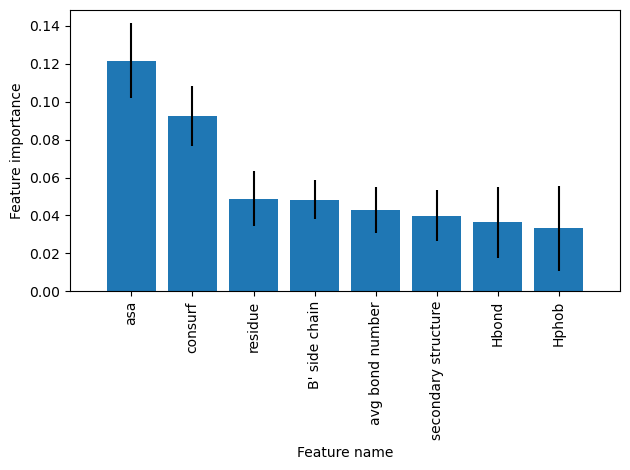

In [33]:
imp_all = all_importance_vals
imp_vals = mean_importance_vals


std = np.std(imp_all, axis=1)
indices = np.argsort(imp_vals)[::-1]

plt.figure()
#plt.title("Feature importance via permutation importance w. std. dev.")
plt.bar(range(len(feat_names_with_ohe)), imp_vals[indices],
        yerr=std[indices])
plt.xticks(range(len(feat_names_with_ohe)),
           np.array(feat_names_with_ohe)[indices], rotation=90)
plt.xlim([-1, len(feat_names_with_ohe)])

plt.ylabel("Feature importance")
plt.xlabel("Feature name")

plt.tight_layout()
plt.savefig('feature-importance.pdf')
plt.show()